# Flagellar Motor Detection Model

In [1]:
import polars as pl
import numpy as np 
import os 
import kagglehub
os.chdir("..")
print( "Current working directory: ", os.getcwd() )


Current working directory:  /Users/anvesh/Documents/Machine_Learing/Flagellar Motor Detection/flagellar_motor_detection_project


/Users/anvesh/miniconda3/envs/flagellar_motor_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## Data Preparation

In [3]:
DATA_DIR = "data/external/3"
data_df = pl.read_csv((DATA_DIR + "/labels.csv"))
data_df

z,y,x,tomo_id,dataset_id
f64,f64,f64,str,i64
67.0,191.170202,345.324574,"""aba2013-04-06-10""",10287
68.0,187.612793,229.115898,"""aba2013-04-06-12""",10287
64.0,481.098988,228.522997,"""aba2013-04-06-13""",10287
61.0,146.702596,236.823617,"""aba2013-04-06-14""",10287
69.0,83.855048,398.092798,"""aba2013-04-06-15""",10287
…,…,…,…,…
74.0,157.066058,411.903802,"""ycw2013-11-24-5""",10139
75.0,167.971277,429.122568,"""ycw2013-11-24-5""",10139
64.0,65.23264,314.330794,"""ycw2013-11-24-5""",10139


In [4]:
print(f"Unique Tomograms: {data_df['tomo_id'].n_unique()}")
print(f"Unique Datasets:  {data_df['dataset_id'].n_unique()}")

Unique Tomograms: 1288
Unique Datasets:  62


### Visualization of the Dataset

In [5]:
ex_idx = 69
row = data_df[ex_idx].to_dict()
row

{'z': shape: (1,)
 Series: 'z' [f64]
 [
 	75.0
 ],
 'y': shape: (1,)
 Series: 'y' [f64]
 [
 	180.184823
 ],
 'x': shape: (1,)
 Series: 'x' [f64]
 [
 	354.29746
 ],
 'tomo_id': shape: (1,)
 Series: 'tomo_id' [str]
 [
 	"aba2014-03-05-18"
 ],
 'dataset_id': shape: (1,)
 Series: 'dataset_id' [i64]
 [
 	10275
 ]}

(128, 512, 512)


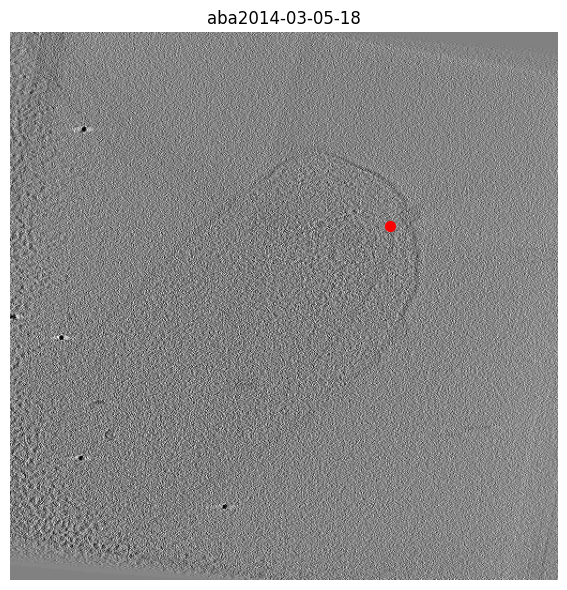

In [6]:
fpath= os.path.join(DATA_DIR, "volumes", row["tomo_id"][0]+".npy")
arr= np.load(fpath)
print(arr.shape)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(row["tomo_id"][0])
ax.imshow(arr[int(row["z"][0]), ...], cmap="gray")
ax.scatter(row["x"][0], row["y"][0], c="red", s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.tight_layout()
plt.show()

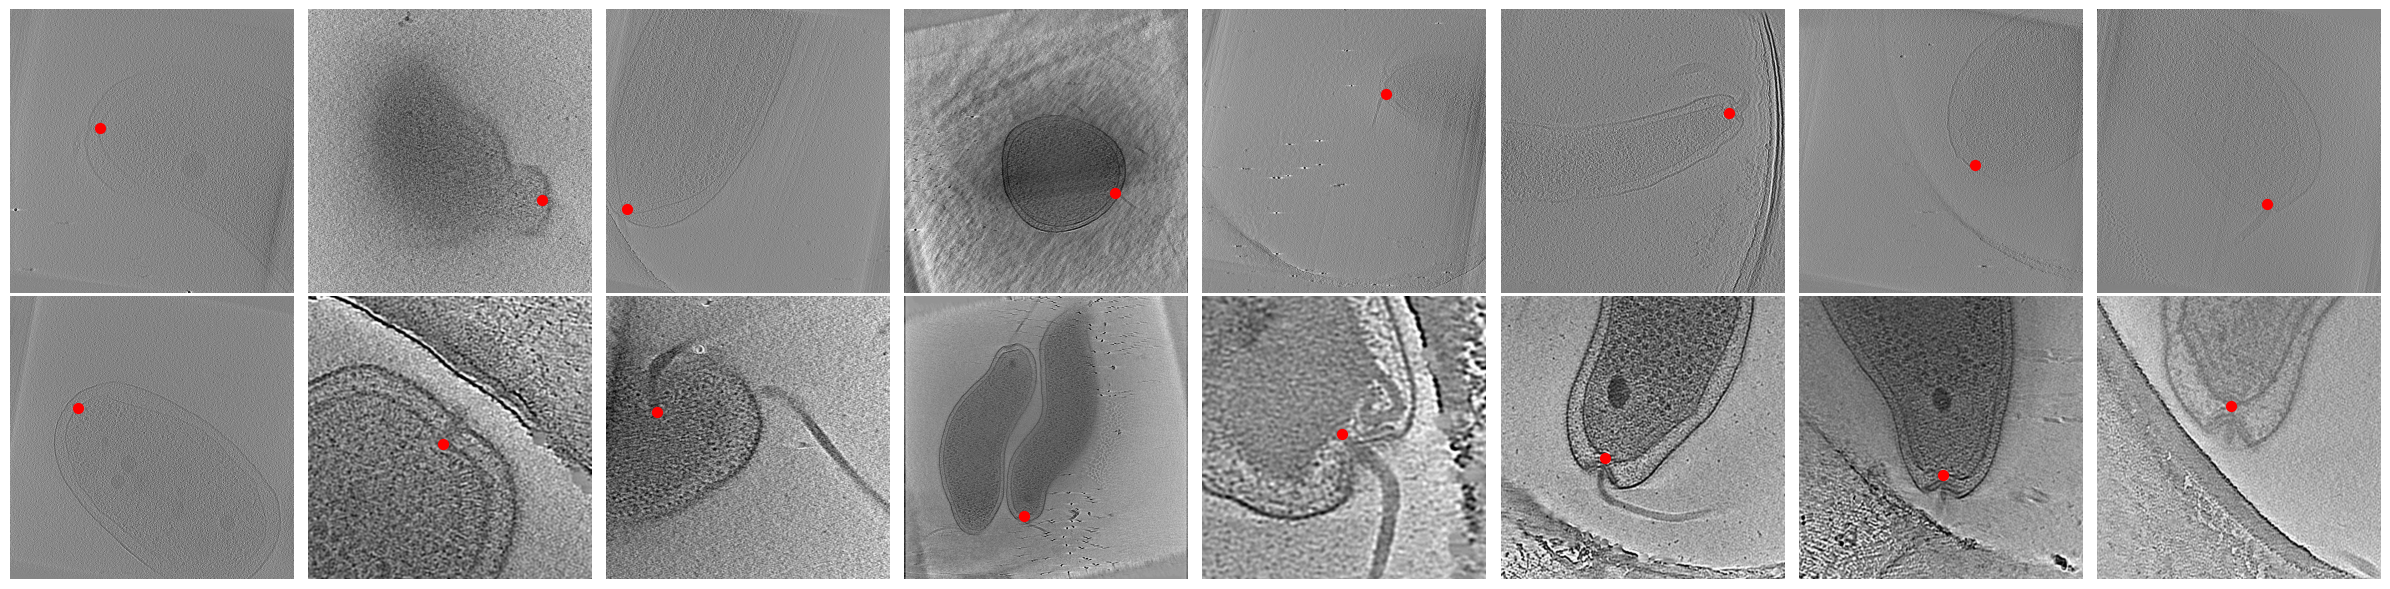

In [12]:
SEED = 0
tmp = (
    data_df
    .group_by("dataset_id")
    .agg(pl.all().sample(1, seed=SEED))
    .explode(["z", "y", "x", "tomo_id"])  # only explode columns that are lists
)
tmp = tmp.sample(n=tmp.height, seed=SEED)

# Create figure
fig, axes = plt.subplots(2, 8, figsize=(24, 6))
axes= axes.flatten()

for idx in range(len(axes)):
    row_tuple = tmp.row(idx)
    row = dict(zip(tmp.columns, row_tuple))

    # Load tomo
    fpath= os.path.join(DATA_DIR, "volumes", row["tomo_id"]+".npy")
    arr= np.load(fpath)

    # Visualize
    # axes[idx].set_title(row["dataset_id"])
    axes[idx].imshow(arr[int(row["z"]), ...], cmap="gray")
    axes[idx].scatter(row["x"], row["y"], c="red", s=50)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_frame_on(False)
    
plt.tight_layout()
plt.show()
plt.show()